In [64]:
import jax
import jax.numpy as jnp
from jax.random import PRNGKey
import matplotlib.pyplot as plt
import relaxed
from functools import partial

# matplotlib settings
plt.rc("figure", figsize=(6, 2), dpi=150, facecolor="w")

# Optimising cuts using gradient descent

This is a simple example to show how you would implement optimisation of cuts for best significance in a differentiable way, and examines some of the trade-offs that one has to make in order to do this.

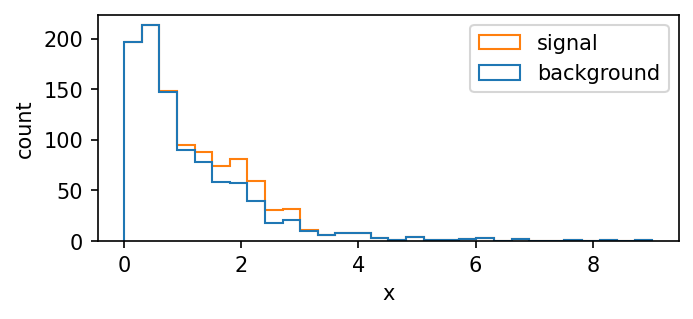

In [28]:
# generate background data from an exponential distribution with a little noise
def generate_background(key, n_samples, n_features, noise_std):
    key, subkey = jax.random.split(key, 2)
    data = jax.random.exponential(subkey, (n_samples, n_features))
    key, subkey = jax.random.split(key, 2)
    data += jax.random.normal(subkey, (n_samples, n_features)) * noise_std
    return data


# generate signal data from a normal distribution close to the background
def generate_signal(key, n_samples, n_features):
    key, subkey = jax.random.split(key, 2)
    data = jax.random.normal(subkey, (n_samples, n_features)) / 2 + 2
    return data


# get 1000 samples from the background and 100 samples from the signal
bkg = generate_background(PRNGKey(0), 1000, 1, 0.1).ravel()
sig = generate_signal(PRNGKey(1), 100, 1).ravel()

sig = sig[sig > 0]
bkg = bkg[bkg > 0]

# plot!
plt.hist(
    [bkg, sig], stacked=True, bins=30, histtype="step", label=["background", "signal"]
)
plt.xlabel("x")
plt.ylabel("count")
plt.legend();

Let's treat this as a one-bin counting experiment, where we'll make a cut (=keep data above/below a threshold value) in order to get a better chance of discovering the signal.

To do this, let's write a function to get the significance, and get its value at a random cut value (that you can change!)

In [29]:
def significance_after_cut(cut):
    # treat analysis as a one-bin counting experiment
    s = len(sig[sig > cut]) + 1e-1
    b = len(bkg[bkg > cut]) + 1e-1
    return relaxed.metrics.asimov_sig(s, b)  # stat-only significance


cut = 2  # change me to change the plot!


def make_cut_plot(cut):
    significance = significance_after_cut(cut)
    plt.hist(
        [bkg, sig],
        stacked=True,
        bins=30,
        histtype="step",
        label=["background", "signal"],
    )
    plt.axvline(x=cut, color="k", linestyle="--", alpha=0.5, label=f"cut = {cut:.2f}")
    plt.axvspan(0, cut, hatch="//", color="grey", alpha=0.3, zorder=-999)
    plt.text(
        0.7,
        0.2,
        f"significance at cut = {significance:.2f}",
        ha="center",
        va="center",
        transform=plt.gca().transAxes,
    )
    plt.xlabel("x")
    plt.ylabel("count")
    plt.legend()
    plt.show()


import ipywidgets as widgets

slider = widgets.FloatSlider(
    value=7.5,
    min=0,
    max=10.0,
    step=0.1,
    description="Cut value:",
    disabled=False,
    continuous_update=True,
    orientation="horizontal",
    readout=True,
    readout_format=".1f",
)
widgets.interactive(make_cut_plot, cut=slider)

interactive(children=(FloatSlider(value=7.5, description='Cut value:', max=10.0, readout_format='.1f'), Output…

What's the best cut we can make? We can find out through a quick grid search over all cut values since this is a toy example:

Text(0, 0.5, 'significance')

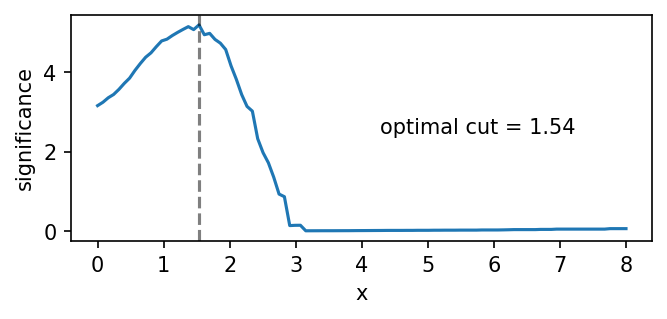

In [30]:
# plot significance for all cut values
cut_values = jnp.linspace(0, 8, 100)
significances_hard = jnp.array([significance_after_cut(cut) for cut in cut_values])
plt.plot(cut_values, significances_hard, label="significance")
optimal_cut = cut_values[jnp.argmax(significances_hard)]
plt.axvline(x=optimal_cut, color="k", linestyle="--", alpha=0.5, label="optimal cut")
plt.text(
    0.7,
    0.5,
    f"optimal cut = {optimal_cut:.2f}",
    ha="center",
    va="center",
    transform=plt.gca().transAxes,
)
plt.xlabel("x")
plt.ylabel("significance")

Now we'll introduce `relaxed.cut`, which is a softened version of a cut that uses the sigmoid function $1/(1+e^{-x})$. Normally, the sigmoid serves to map values on the real line to [0,1], so we leverage this to be used as a cut by applying it to data, which results in a set of weights for each point in [0,1]. (A normal cut does this too, but the weights are all 0 or 1, and you drop the 0s. One could similarly threshold on a minimum weight value here.)

Practically, we introduce slope and intercept terms that control the sigmoid's x position and how "hard" the cut is: $1/(1+e^{-\mathrm{slope}(x-\mathrm{cut~value}})$. High slopes mean less approximate cuts, but at the risk of gradient instability.

Let's look at this in practice:

In [81]:
cut_val = 2  # translates on the x-axis


def sigmoid_plot(slope):
    fig, axs = plt.subplots(1, 2)
    ax = axs[0]
    ax.plot(cut_values, cut_values > cut_val, label="hard cut", linestyle="dotted")
    ax.plot(
        cut_values,
        relaxed.cut(cut_values, cut_val, slope=slope),
        label=f"sigmoid",
        color="C1",
        alpha=0.6,
    )
    ax.set_ylabel("weight applied at x")
    ax.set_xlabel("x")
    ax.legend(
        bbox_to_anchor=(0, 1.02, 1, 0.2),
        loc="lower left",
        mode="expand",
        borderaxespad=0,
        ncol=1,
        title="profile of the cut itself:",
        frameon=False,
    )
    ax = axs[1]
    bins = jnp.linspace(0, 8, 31)
    ax.hist(
        jnp.concatenate([bkg[bkg > cut_val], sig[sig > cut_val]]),
        bins=bins,
        histtype="step",
        label="data (hard cut)",
        linestyle="dotted",
    )
    sig_w = relaxed.cut(sig, cut_val, slope)
    bkg_w = relaxed.cut(bkg, cut_val, slope)
    ax.hist(
        jnp.concatenate([bkg, sig]),
        weights=jnp.concatenate([bkg_w, sig_w]),
        bins=bins,
        histtype="step",
        label="data (sigmoid)",
        alpha=0.6,
    )
    #     ax.set_xlim((0,8))
    ax.axvline(x=cut_val, color="k", linestyle="--", alpha=0.5)
    ax.set_xlabel("x")
    ax.legend(
        bbox_to_anchor=(0, 1.02, 1, 0.2),
        loc="lower left",
        mode="expand",
        borderaxespad=0,
        ncol=1,
        title="histograms of data afer cut:",
        frameon=False,
    )


slider = widgets.FloatSlider(
    value=7.5,
    min=0.01,
    max=20.0,
    step=0.001,
    description="Slope:",
    disabled=False,
    continuous_update=True,
    orientation="horizontal",
    readout=True,
    readout_format=".1f",
)
widgets.interactive(sigmoid_plot, slope=slider)

interactive(children=(FloatSlider(value=7.5, description='Slope:', max=20.0, min=0.01, readout_format='.1f', s…

Since the cuts are approximate, the significance will also be approximate. Not to worry, as we're going to use the optimised cut value in an analysis with actual cuts (although there's nothing stopping us from using the soft cuts instead), and trust that the optimised cut value is still good. We can do this if the soft cut-significance faithfully represents the shape of the actual significance, which we can check:

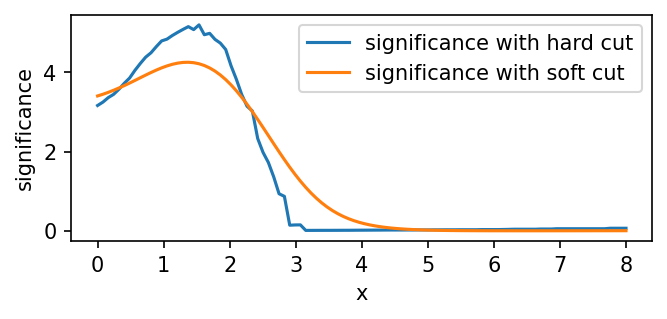

In [33]:
def significance_after_soft_cut(cut, slope):
    s_weights = (
        relaxed.cut(sig, cut, slope) + 1e-4
    )  # add small offset to avoid 0 weights
    b_weights = relaxed.cut(bkg, cut, slope) + 1e-4
    return relaxed.metrics.asimov_sig(s_weights.sum(), b_weights.sum())


# choosing the cut slope: increasing slope reduces bias but also noises gradients.
# I increased it until gradients were nan in the next step, then went a touch lower.
# I'll think about a more principled way to do this (suggestions welcome!)
slope = 2.7

# plot significance for all cut values
cut_values = jnp.linspace(0, 8, 100)
soft = partial(significance_after_soft_cut, slope=slope)
significances = jax.vmap(soft, in_axes=(0))(cut_values)
plt.plot(cut_values, significances_hard, label="significance with hard cut")
plt.plot(cut_values, significances, label="significance with soft cut")
plt.xlabel("x")
plt.ylabel("significance")
plt.legend();

Looks like the maxima of the significance are in the same region as the softened version, so we're good to go from an optimisation standpoint!

We'll use gradient descent through the adam optimiser, and see how we do.

In [34]:
from jaxopt import OptaxSolver
from optax import adam

# define something to minimise (1/significance)
def loss(cut):
    s_weights = relaxed.cut(sig, cut, slope) + 1e-4
    b_weights = relaxed.cut(bkg, cut, slope) + 1e-4
    return 1 / relaxed.metrics.asimov_sig(s_weights.sum(), b_weights.sum())


# play with the keyword arguments to the optimiser if you want :)
solver = OptaxSolver(loss, adam(learning_rate=1e-2), maxiter=10000, tol=1e-6)
init = 6.0
cut_opt = solver.run(init).params
cut_opt

DeviceArray(1.3574117, dtype=float32)

Okay, now let's see how good we did!

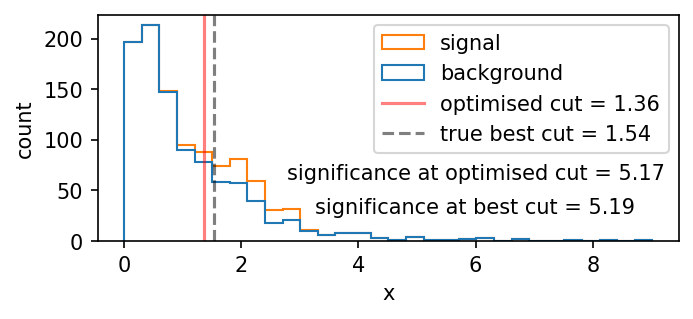

In [39]:
significance = significance_after_cut(cut_opt)
plt.hist(
    [bkg, sig], stacked=True, bins=30, histtype="step", label=["background", "signal"]
)
plt.axvline(
    x=cut_opt,
    color="r",
    linestyle="-",
    alpha=0.5,
    label=f"optimised cut = {cut_opt:.2f}",
)
significance = significance_after_cut(cut_opt)
plt.axvline(
    x=optimal_cut,
    color="k",
    linestyle="--",
    alpha=0.5,
    label=f"true best cut = {optimal_cut:.2f}",
)
plt.text(
    0.65,
    0.3,
    f"significance at optimised cut = {significance:.2f}",
    ha="center",
    va="center",
    transform=plt.gca().transAxes,
)
plt.text(
    0.65,
    0.15,
    f"significance at best cut = {significance_after_cut(optimal_cut):.2f}",
    ha="center",
    va="center",
    transform=plt.gca().transAxes,
)
plt.xlabel("x")
plt.ylabel("count")
plt.legend();

On my computer, we're .01 away from the best significance, so I'm pretty happy with that ;)

Thanks go to Alex Held, who provided a very similar nice example in the early days that I used as inspiration ([see here](https://github.com/alexander-held/differentiable-analysis-example/blob/master/Significance_optimization.ipynb))